# Project 2 IMDB Classification

## Init 

In [553]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [554]:
# Load Data
dataset=pd.read_csv('data/train_dataset.csv')
dataset.drop(columns=['id'], inplace=True)

In [555]:
# Preview Data
dataset.shape
dataset.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality,imdb_score_binned
0,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,Adventure|Animation|Drama|Family|Musical,Matthew Broderick,...,656,English,USA,G,1994,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576,4
1,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,Horror,Tony Nappo,...,662,English,Canada,R,2005,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675,2
2,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,Drama,Nicolas Cage,...,118,English,USA,R,2013,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002,2
3,John Carpenter,297,109,0,145,Richard Masur,957,13782838,Horror|Mystery|Sci-Fi,Wilford Brimley,...,911,English,USA,R,1982,163,23000,[-5.32674184e-03 3.60742491e-03 7.91795843e-...,0.001726,4
4,Peter Jackson,297,171,0,857,Orlando Bloom,16000,313837577,Action|Adventure|Drama|Fantasy,Christopher Lee,...,5060,English,New Zealand,PG-13,2001,5000,21000,[-4.2586620e-03 3.6257182e-03 -1.5326265e-03 ...,0.001876,4


In [556]:
# Seperate dataset into features and classes
y = dataset['imdb_score_binned']
dataset.drop(columns=['imdb_score_binned'], inplace=True)
X = dataset

## Class Distribution

In [557]:
# We will find the mean imdb score
mean_imdb_score = y.mean()
print(mean_imdb_score)

2.2503328894806924


imdb_score_binned


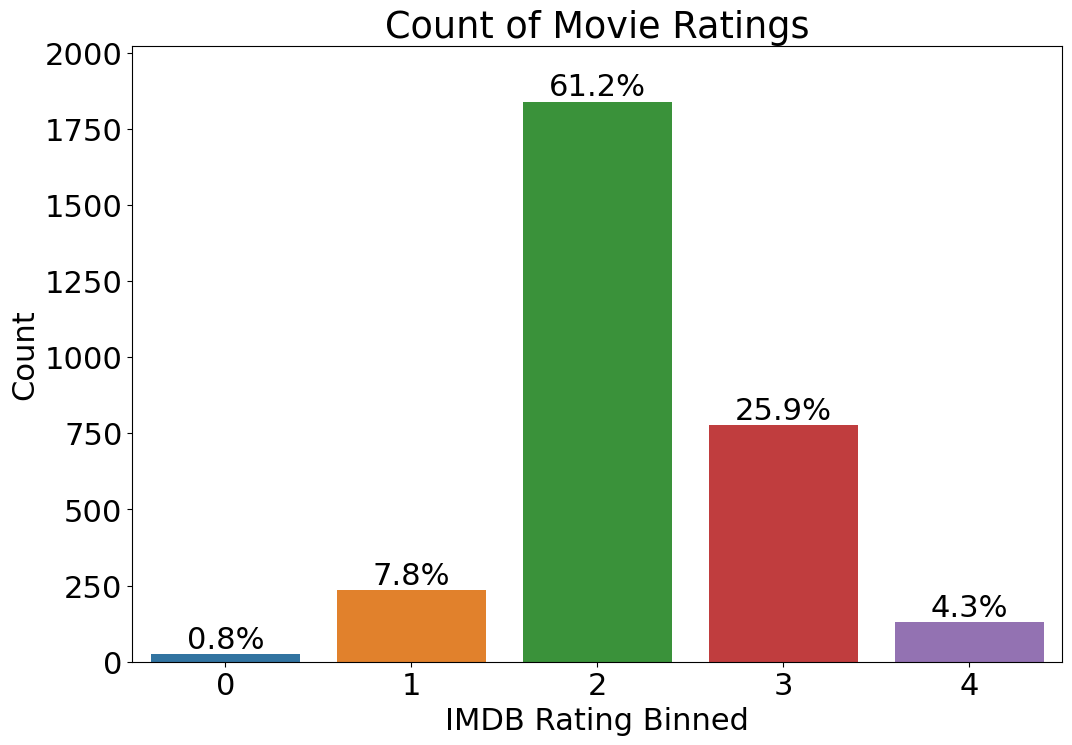

In [558]:
# Making a histogram of count of imdb score
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12,8))
print(y.name)

ax = sns.countplot(x=y.name, data=y.to_frame())
plt.title('Count of Movie Ratings')
plt.xlabel('IMDB Rating Binned')
plt.ylabel('Count')
total = y.count()
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.1f}%')
ax.margins(y=0.1)
plt.show()

## Data Preprocessing

### Normalisation

In [559]:
# We will standardise some of the features. We will use z-score standardisation as it is better for zero mean models.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [560]:
# Get all numeric attributes except those that don't make sense to be standardised
numeric = X.select_dtypes(include='number')
numeric.drop(columns=['title_year'], inplace=True)
numeric.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'actor_2_facebook_likes',
       'movie_facebook_likes', 'average_degree_centrality'],
      dtype='object')

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


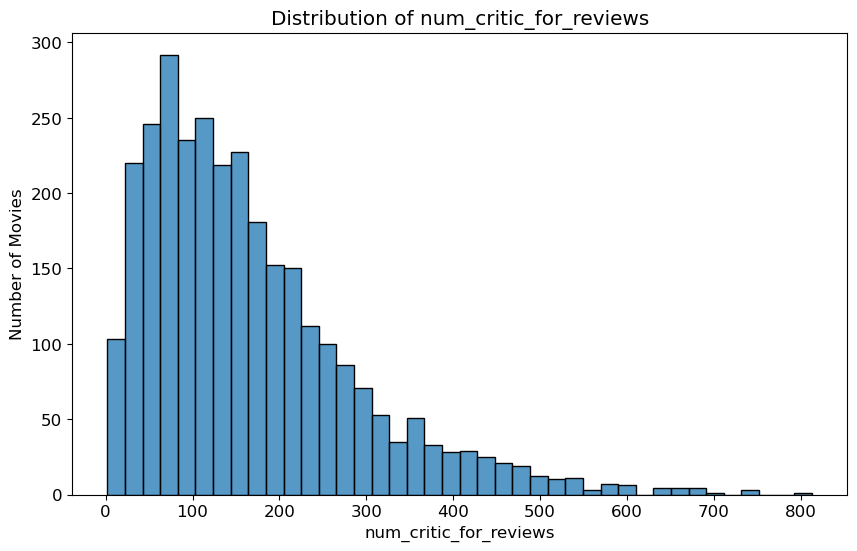

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


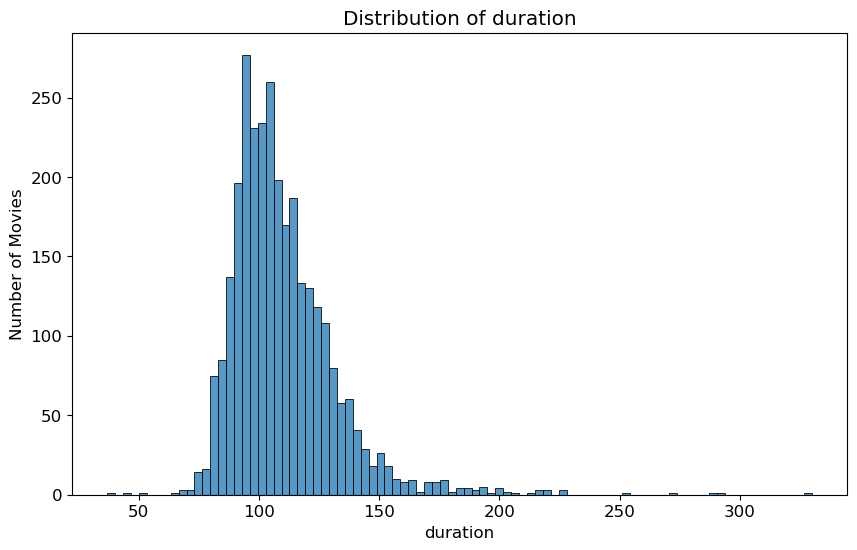

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


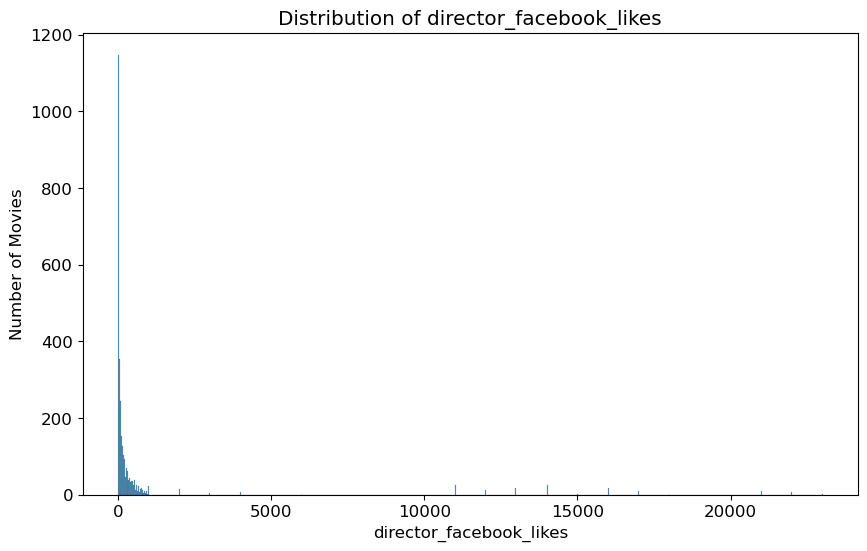

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


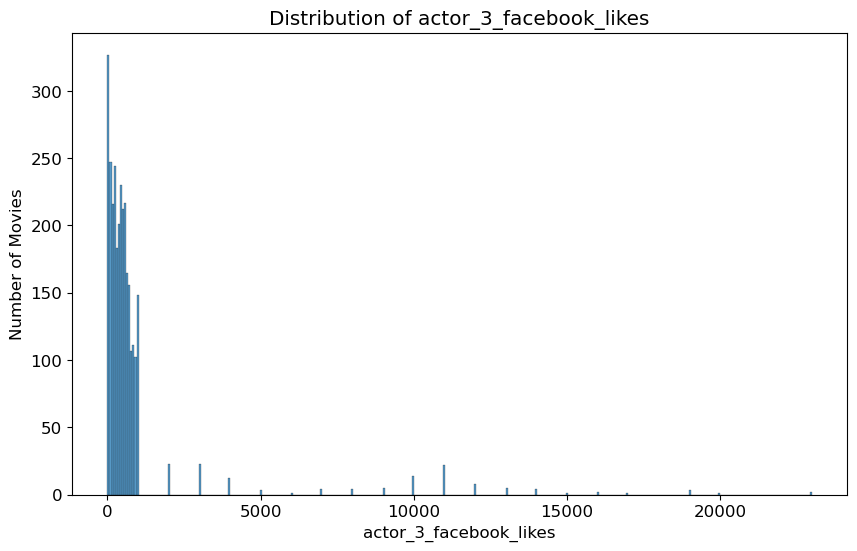

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


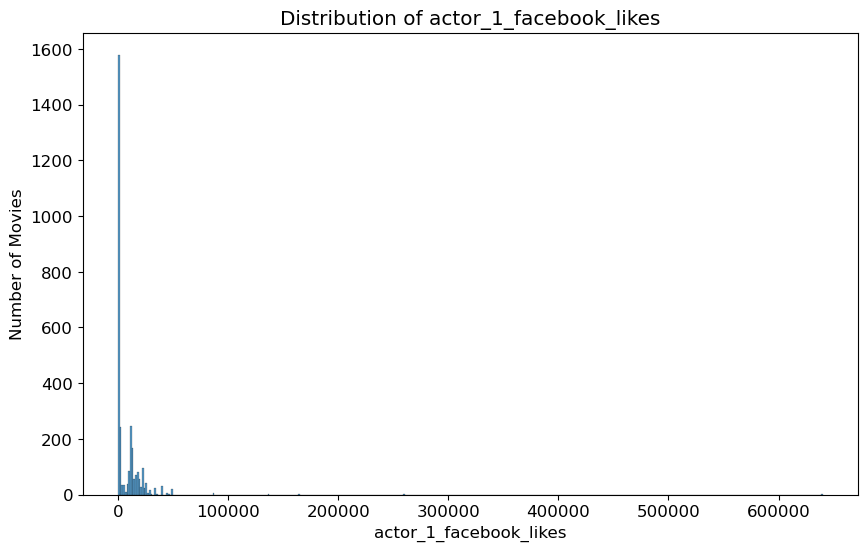

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


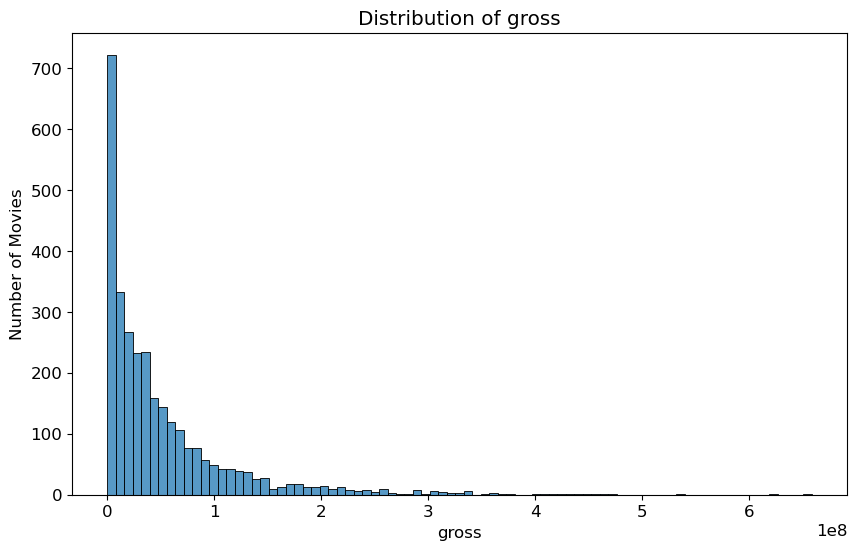

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


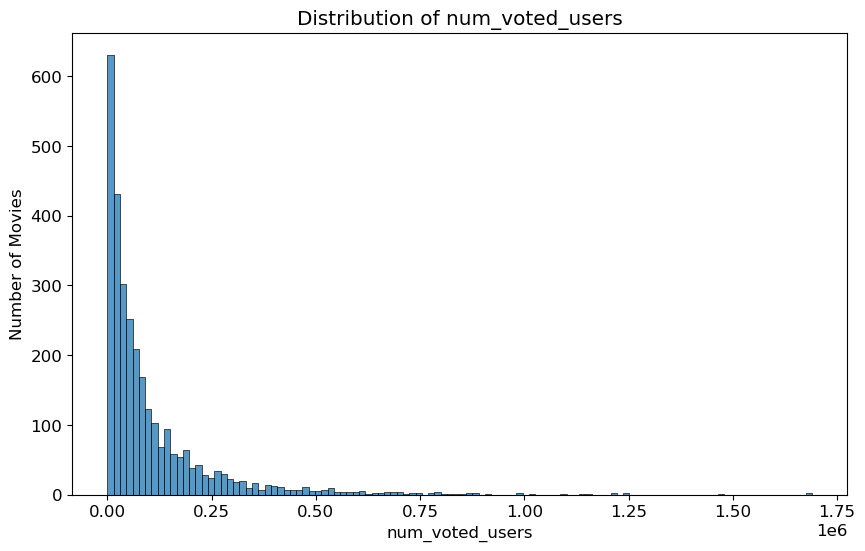

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


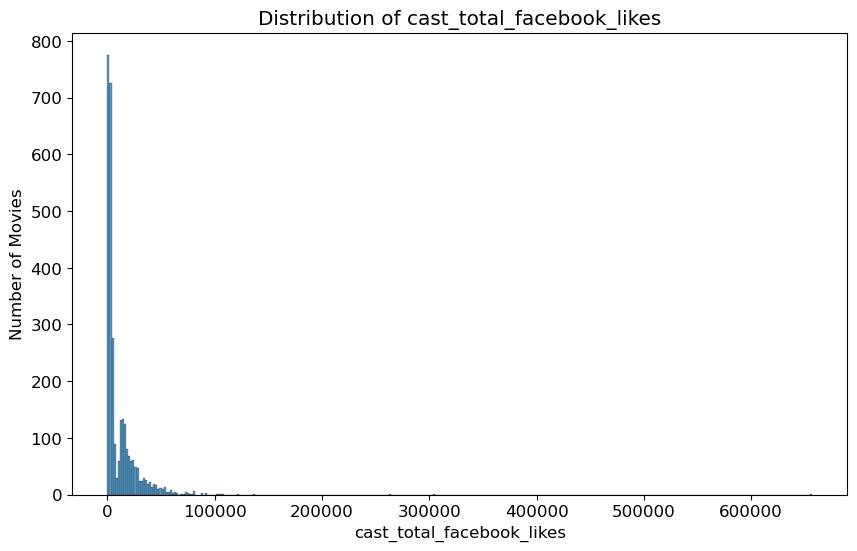

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


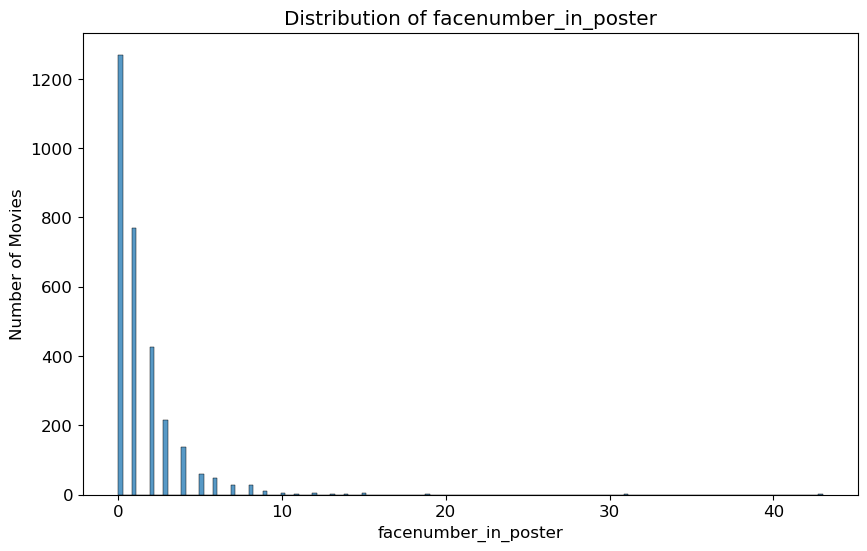

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


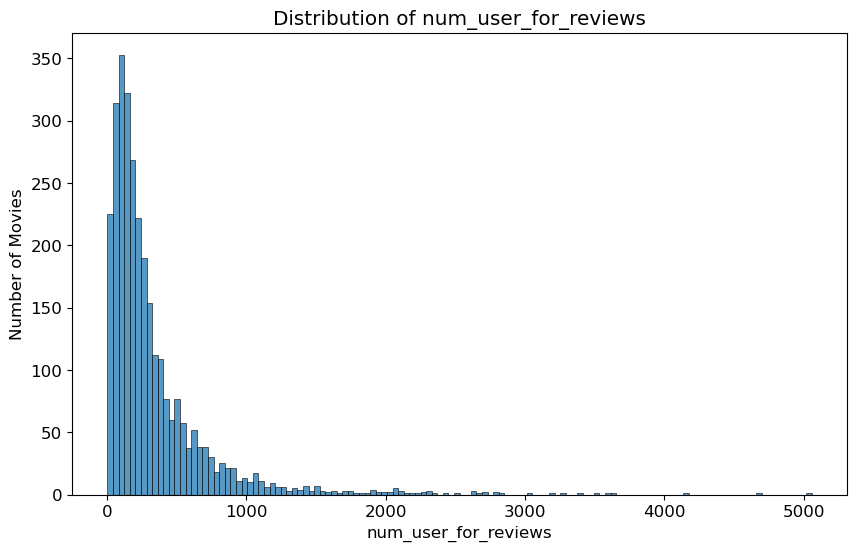

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


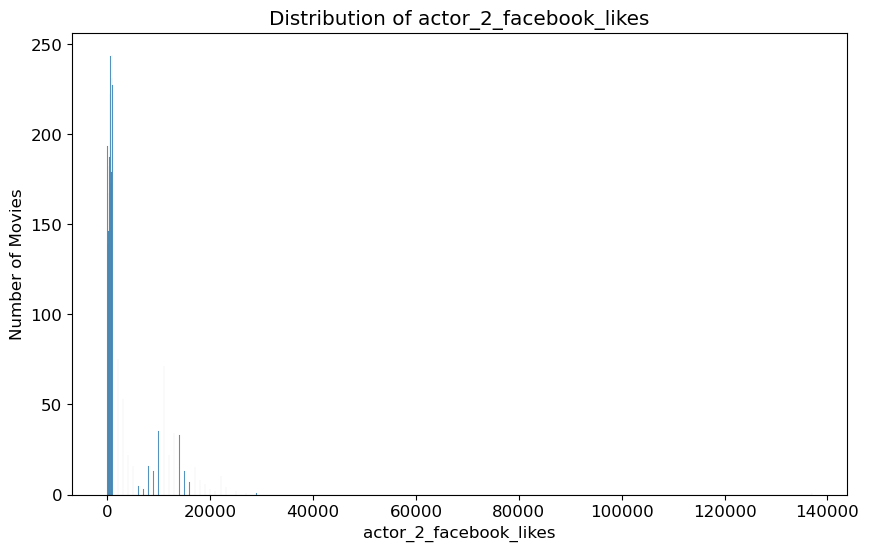

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


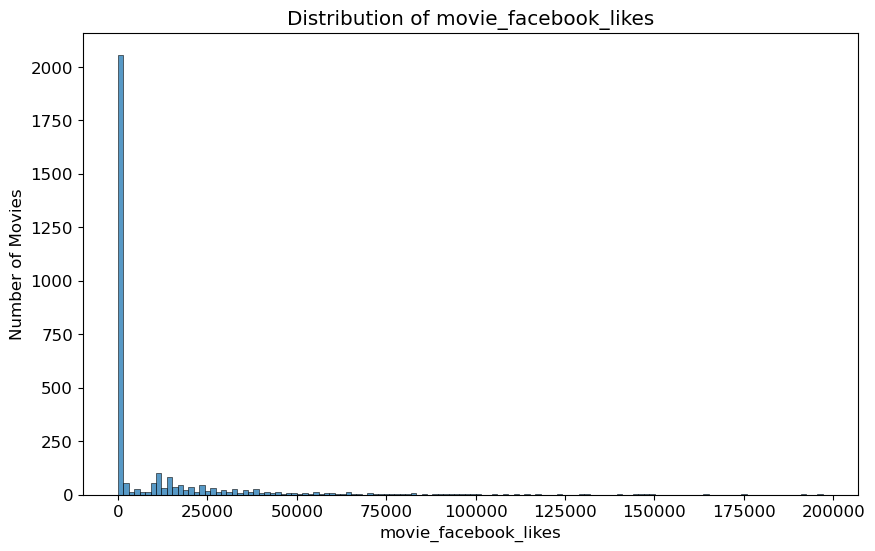

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


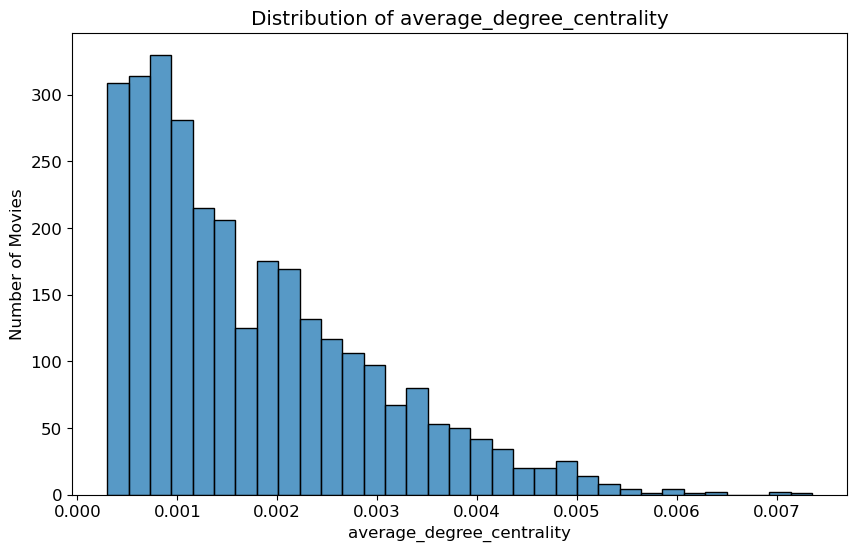

In [561]:
plt.rcParams.update({'font.size': 12})
# Check distributions before normalisation
for c in numeric.columns:
    # Looking at the distribution of the duration of the movies
    plt.figure(figsize=(10,6))
    sns.histplot(X[c])
    plt.title(f'Distribution of {c}')
    plt.xlabel(c)
    plt.ylabel('Number of Movies')
    plt.show()

In [562]:
# Normalise the fields
for c in numeric.columns:
    X[c] = scaler.fit_transform(X[[c]])

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


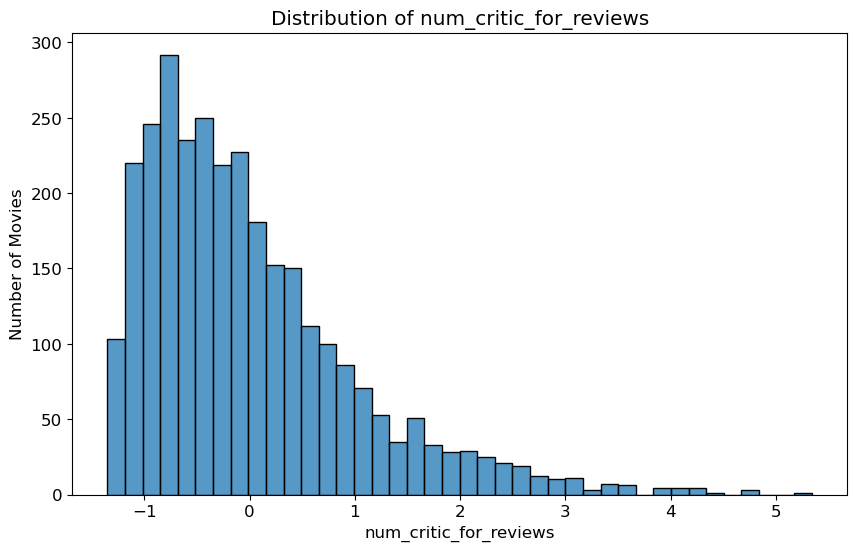

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


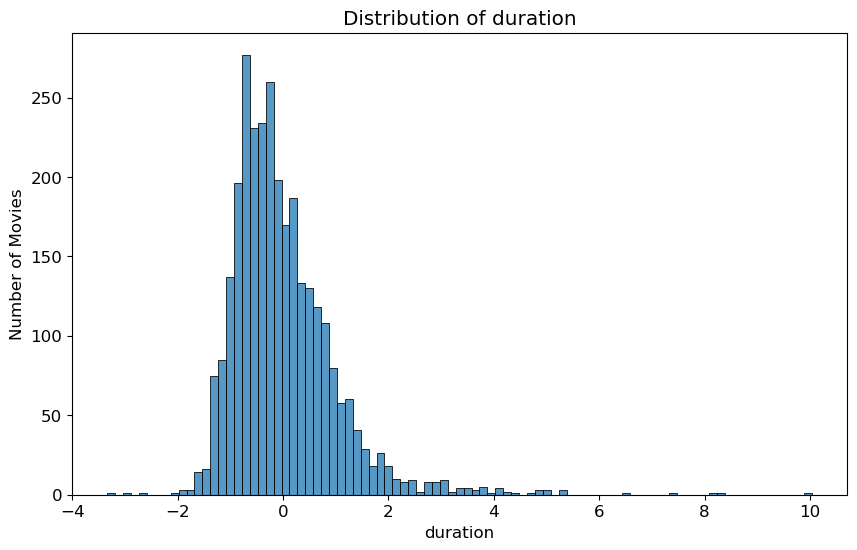

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


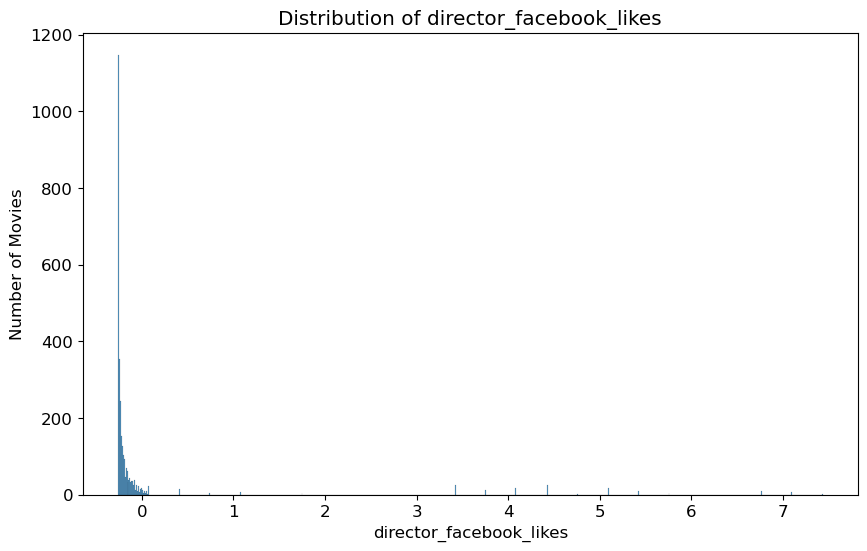

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


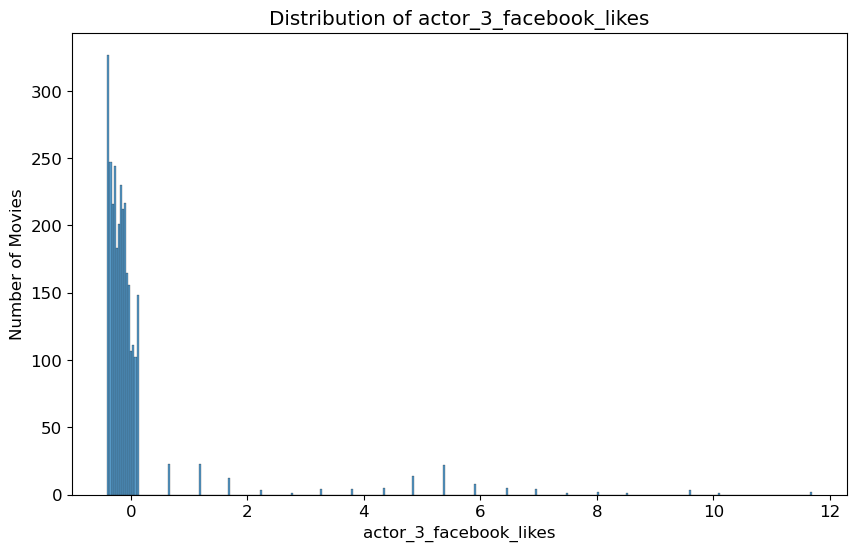

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


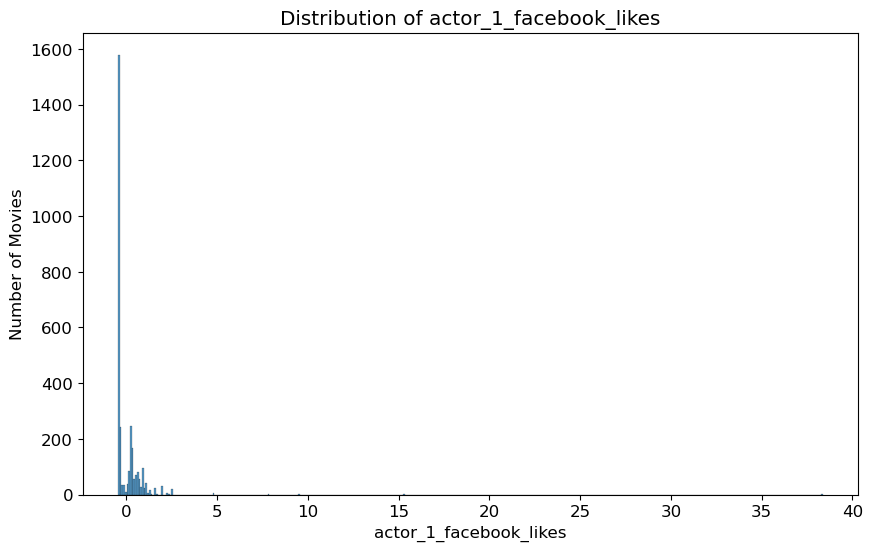

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


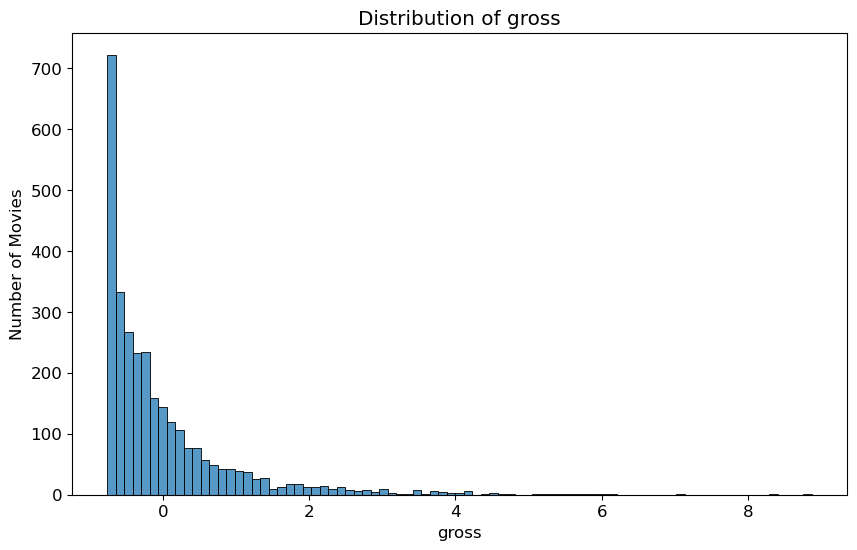

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


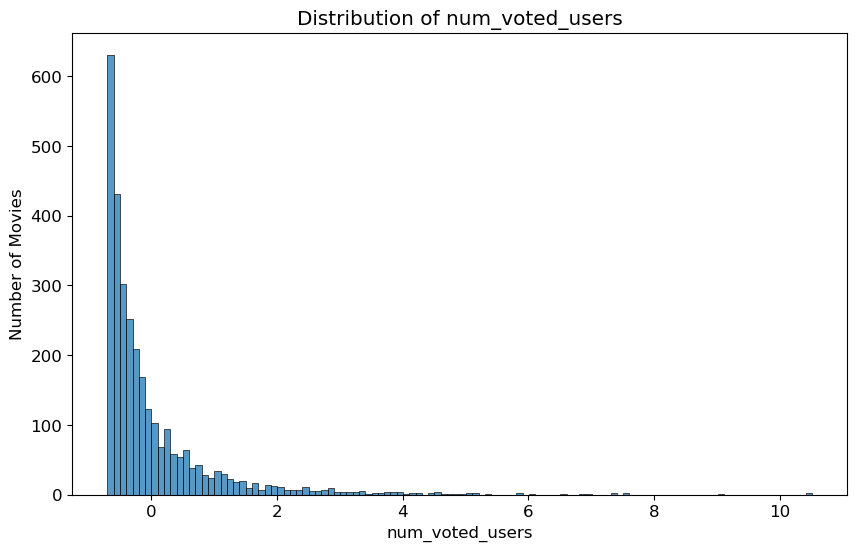

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


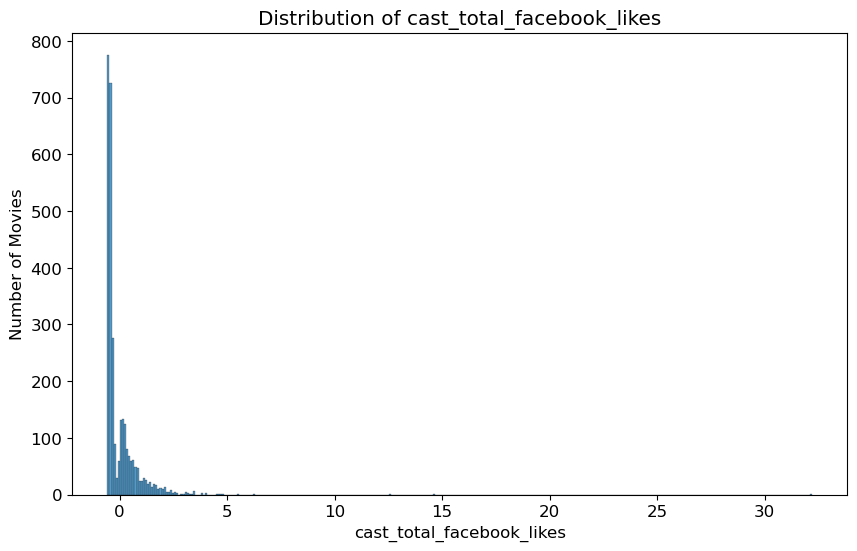

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


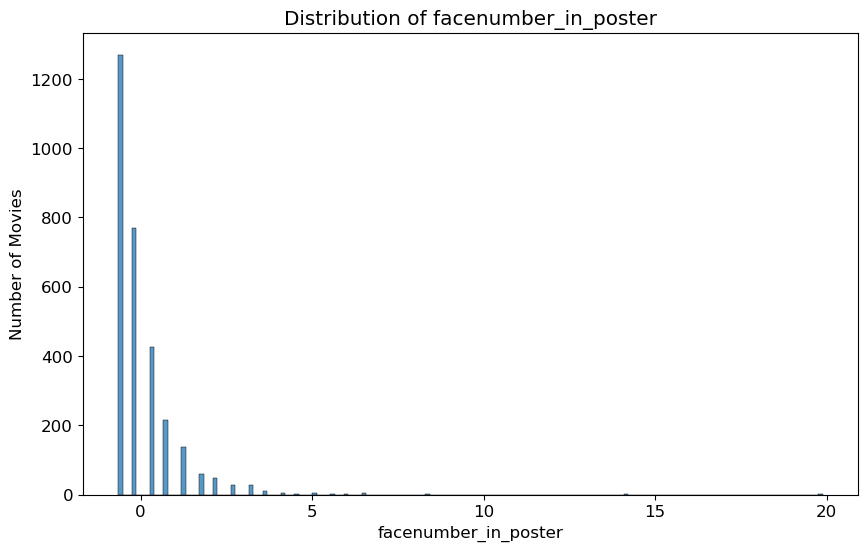

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


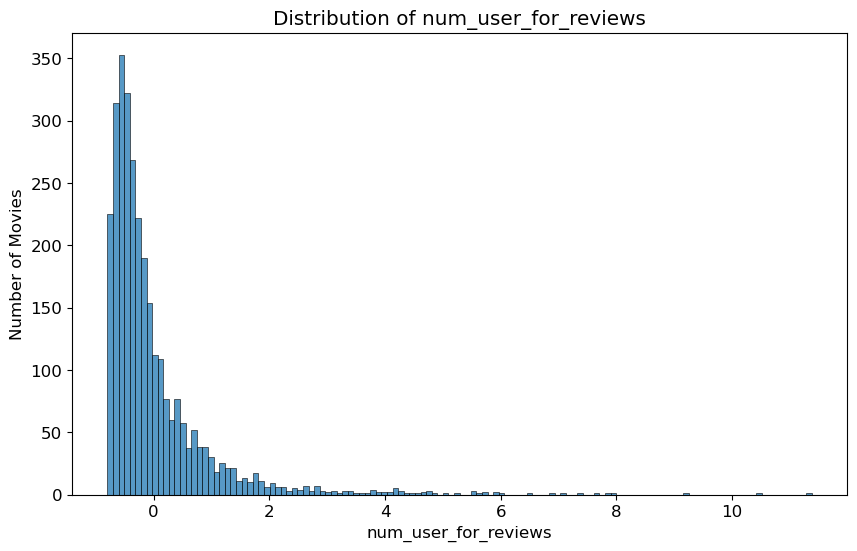

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


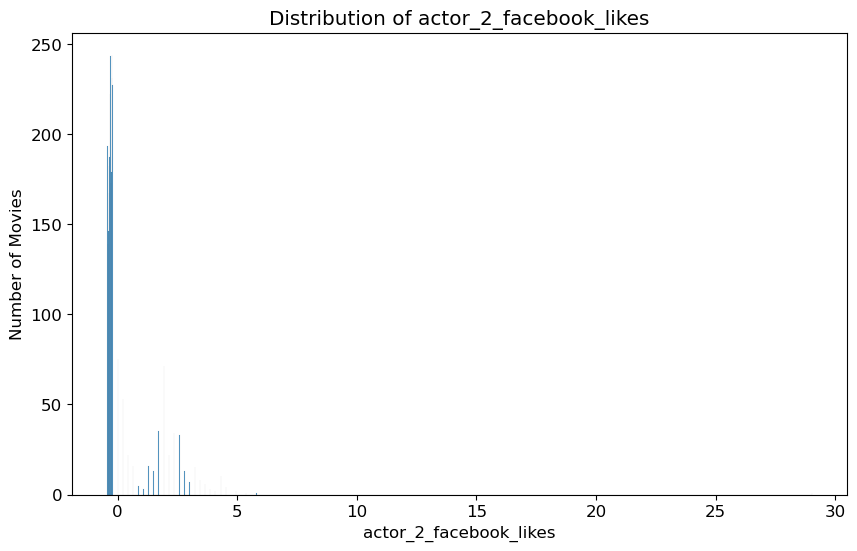

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


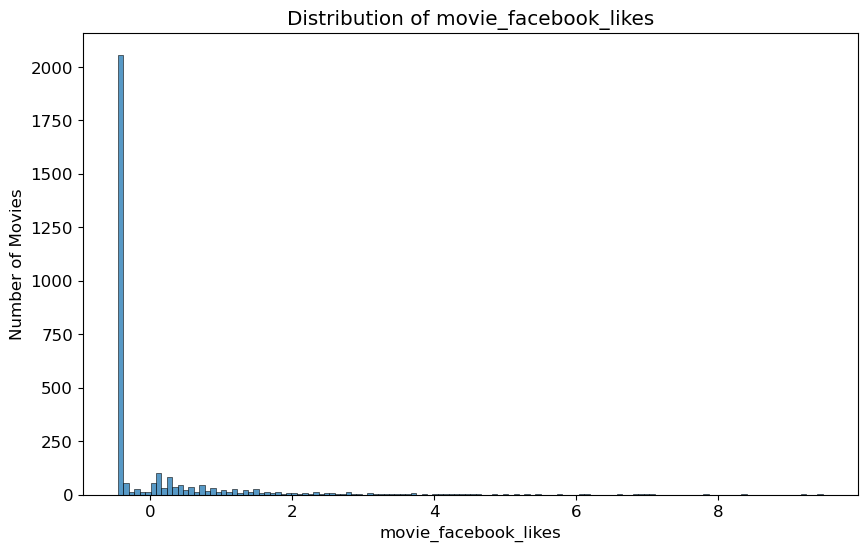

/home/taherm/software/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


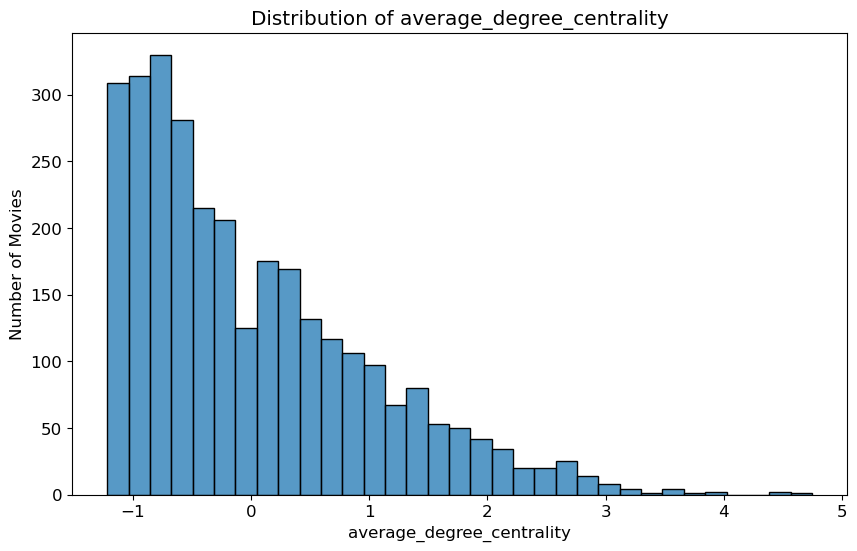

In [563]:
# Check fields are normalised
for c in numeric.columns:
    # Looking at the distribution of the duration of the movies
    plt.figure(figsize=(10,6))
    sns.histplot(X[c])
    plt.title(f'Distribution of {c}')
    plt.xlabel(c)
    plt.ylabel('Number of Movies')
    plt.show()

### Correlation

      imdb_score_binned
0                     4
1                     2
2                     2
3                     4
4                     4
...                 ...
2999                  2
3000                  4
3001                  3
3002                  3
3003                  3

[3004 rows x 1 columns]


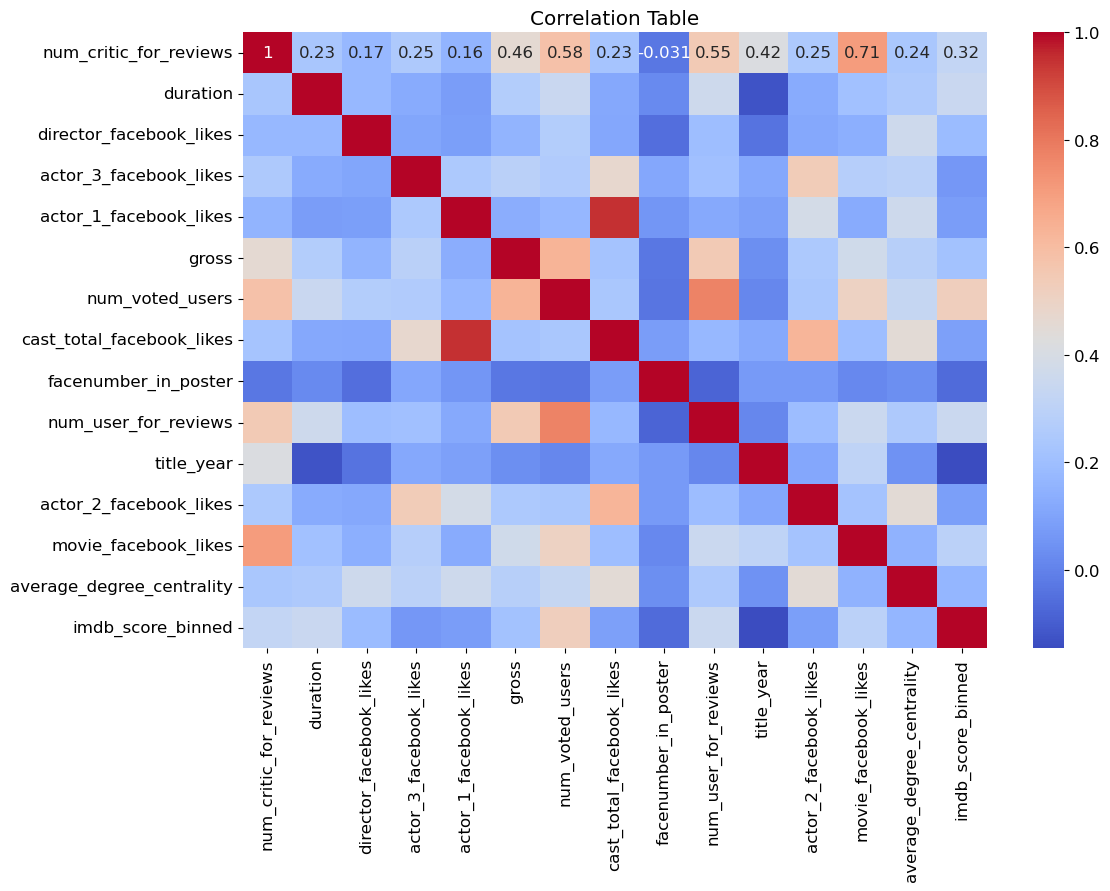

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,title_year,actor_2_facebook_likes,movie_facebook_likes,average_degree_centrality,imdb_score_binned
0,0.168193,-1.692456,-0.251113,0.041616,-0.343014,5.423388,3.576467,-0.246173,-0.659713,0.770991,1994,-0.238016,0.404412,-0.137497,4
1,0.712593,-0.596914,-0.260477,-0.281257,-0.424659,-0.459765,-0.172501,-0.474800,3.162426,0.785444,2005,-0.314785,-0.451986,-0.898628,2
2,0.547624,0.316038,-0.182223,-0.287568,0.263561,-0.753112,-0.453535,0.110539,0.295821,-0.524925,2013,-0.213501,0.102154,1.067627,2
3,1.083775,-0.049143,-0.260477,-0.327532,-0.406280,-0.557017,1.015541,-0.480737,-0.659713,1.385226,1982,-0.393489,0.706670,-0.010642,4
4,1.083775,2.781008,-0.260477,0.046874,0.506190,3.830379,7.517258,0.546387,0.295821,11.379196,2001,0.646659,0.605918,0.116214,4


In [564]:
# We will do a correlation table between all the columns.
print(y.to_frame())
data = pd.concat([X.select_dtypes(include='number'), y.to_frame()], axis=1)
correlation = (data).corr()
# We will plot the correlation table
plt.figure(figsize=(12,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Table')
plt.show()
data.head()

### Removing Attributes

#### Removing Highly Correlated Attributes

In [565]:
# cast_total_facebook_likes are correlated heavily with actor_1_facebook_likes, actor_2_facebook_likes, and actor_3_facebook_likes, so we drop the actor facebook likes
X.drop(columns=['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes'], inplace=True)

# num_voted_users and num_user_for_reviews are highly correlated, so we drop the number of user reviews
X.drop(columns=['num_user_for_reviews'], inplace=True)

#### Removing Text Attributes

In [566]:
# We will drop the id, director name, actor names, movie title columns, and plot keywords.
X.drop(columns=['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'movie_title', 'plot_keywords'], inplace=True)

# Removing title embedding
X.drop(columns=['title_embedding'], inplace=True)

#### Removing Attributes without much variation
These attributes have a lot of unique values, with one value being predominant

In [567]:
X.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'gross', 'genres', 'num_voted_users', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'movie_facebook_likes', 'average_degree_centrality'],
      dtype='object')

In [568]:
""" for c in X.columns:
    plt.figure(figsize=(30,8))
    sns.countplot(x=c, data=X)
    plt.title(f'Count of Movies {c}')
    plt.xlabel(c)
    plt.ylabel('Count')
    plt.show() """

" for c in X.columns:\n    plt.figure(figsize=(30,8))\n    sns.countplot(x=c, data=X)\n    plt.title(f'Count of Movies {c}')\n    plt.xlabel(c)\n    plt.ylabel('Count')\n    plt.show() "

In [569]:
X.drop(columns=['country', 'language', 'content_rating'], inplace=True)
X.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'gross', 'genres', 'num_voted_users', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'title_year', 'movie_facebook_likes',
       'average_degree_centrality'],
      dtype='object')

### Get doc2vec data for plot.

This is for vectorizing plot, basically a better bagofwords. If we want to use the movie's plot as a feature instead of useing words we should use this.

In [570]:
doc2vec_plot_data = np.load('data/features_doc2vec/train_doc2vec_features_plot_keywords.npy')

We are assuming that if we have a movie that has a higly related plot point to a film in training dataset then the movie will have a similar score.


In [571]:
from sklearn.metrics.pairwise import cosine_similarity

doc2vec_scaled = scaler.fit_transform(doc2vec_plot_data)
# Now we create a similarity matrix using cosine similarity
similarity_matrix = cosine_similarity(doc2vec_scaled)

In [572]:
# We will now create a matrix that is a matrix of difference of rating between movies
imdb_score_matrix = np.array(y)
imdb_score_matrix = imdb_score_matrix.reshape(-1,1)
imdb_score_matrix = np.repeat(imdb_score_matrix, len(imdb_score_matrix), axis=1)
imdb_score_matrix = np.abs(imdb_score_matrix - imdb_score_matrix.T)


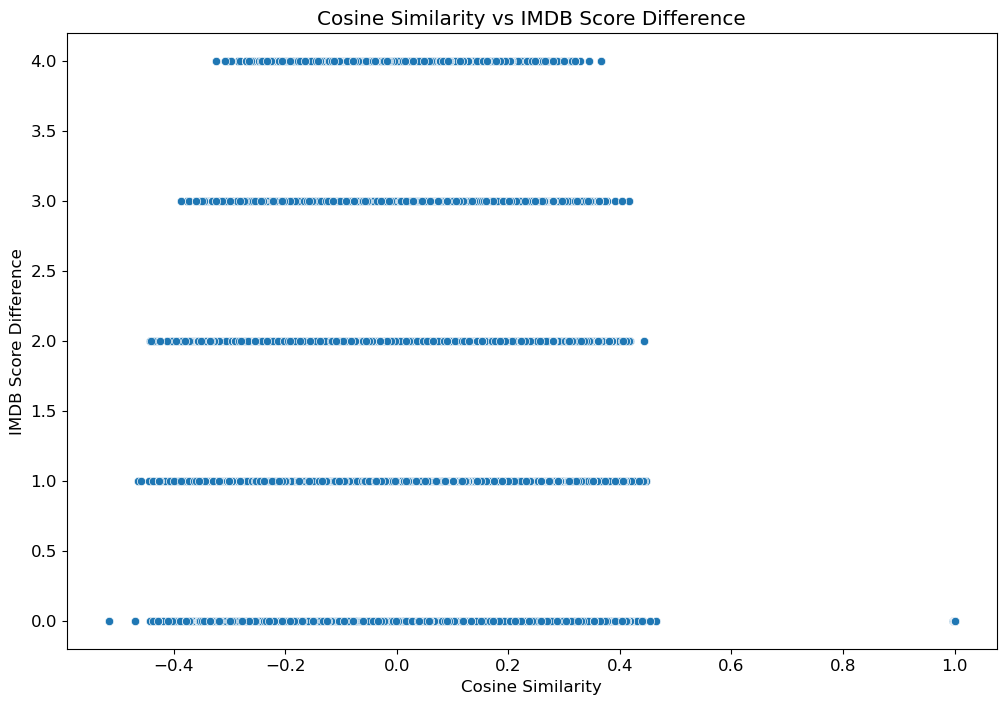

In [573]:
# Now we will scatter plot cosine similarity and imdb score difference
plt.figure(figsize=(12,8))
sns.scatterplot(x=similarity_matrix.flatten(), y=imdb_score_matrix.flatten())
plt.title('Cosine Similarity vs IMDB Score Difference')
plt.xlabel('Cosine Similarity')
plt.ylabel('IMDB Score Difference')
plt.show()


### One Hot Encoding Genres

In [574]:
# We have a genre column which has multiple genres separated by '|'. We will split these genres into separate columns.
# We will first find all the unique genres
unique_genres = set()
for genre in X['genres']:
    genre_list = genre.split('|')
    for g in genre_list:
        unique_genres.add(g)
unique_genres = list(unique_genres)
print(unique_genres)
# Now we split the genres into separate columns
for genre in unique_genres:
    X[genre] = X['genres'].str.contains(genre).astype(int)
X.drop(columns=['genres'], inplace=True)
X.head()


['Romance', 'Horror', 'Thriller', 'Musical', 'Adventure', 'Action', 'Biography', 'Mystery', 'Documentary', 'Drama', 'War', 'Fantasy', 'Western', 'Film-Noir', 'Family', 'Crime', 'Comedy', 'Music', 'Sci-Fi', 'History', 'Animation', 'Sport']


,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,title_year,movie_facebook_likes,average_degree_centrality,...,Western,Film-Noir,Family,Crime,Comedy,Music,Sci-Fi,History,Animation,Sport
0,0.168193,-1.692456,-0.251113,5.423388,3.576467,-0.246173,-0.659713,1994,0.404412,-0.137497,...,0,0,1,0,0,1,0,0,1,0
1,0.712593,-0.596914,-0.260477,-0.459765,-0.172501,-0.474800,3.162426,2005,-0.451986,-0.898628,...,0,0,0,0,0,0,0,0,0,0
2,0.547624,0.316038,-0.182223,-0.753112,-0.453535,0.110539,0.295821,2013,0.102154,1.067627,...,0,0,0,0,0,0,0,0,0,0
3,1.083775,-0.049143,-0.260477,-0.557017,1.015541,-0.480737,-0.659713,1982,0.706670,-0.010642,...,0,0,0,0,0,0,1,0,0,0
4,1.083775,2.781008,-0.260477,3.830379,7.517258,0.546387,0.295821,2001,0.605918,0.116214,...,0,0,0,0,0,0,0,0,0,0


In [575]:
# We will also store the genres in a separate variable because we want to do stepwise selection for feature selection
genres = X[unique_genres]
X.drop(columns=unique_genres, inplace=True)
X.head()

,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,title_year,movie_facebook_likes,average_degree_centrality
0,0.168193,-1.692456,-0.251113,5.423388,3.576467,-0.246173,-0.659713,1994,0.404412,-0.137497
1,0.712593,-0.596914,-0.260477,-0.459765,-0.172501,-0.474800,3.162426,2005,-0.451986,-0.898628
2,0.547624,0.316038,-0.182223,-0.753112,-0.453535,0.110539,0.295821,2013,0.102154,1.067627
3,1.083775,-0.049143,-0.260477,-0.557017,1.015541,-0.480737,-0.659713,1982,0.706670,-0.010642
4,1.083775,2.781008,-0.260477,3.830379,7.517258,0.546387,0.295821,2001,0.605918,0.116214


## Model

In [576]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

# Assuming X and y are defined elsewhere in your code:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [577]:
X_genres = pd.concat([X, genres], axis=1)
# Adding genres to training set
X_train_genres = pd.concat([X_train, genres.iloc[X_train.index]], axis=1)
# Adding genres to test set
X_test_genres = pd.concat([X_test, genres.iloc[X_test.index]], axis=1)

In [578]:
class Model:
    def __init__(self, estimator, param_grid):
        self.estimator = estimator
        self.param_grid = param_grid

    def grid_search(self, cv=5, n_jobs=-1, verbose=False, refit=True):
        self.gs = GridSearchCV(self.estimator, param_grid=self.param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose, refit=refit)
    
    def get_best_model(self, X_train, y_train):
        self.gs.fit(X_train, y_train)
        self.best_estimator = self.gs.best_estimator_
        self.best_params = self.gs.best_params_
        self.best_cv = self.gs.best_score_
        return self.best_estimator, self.best_params, self.best_cv 

    def predict(self, X_test):
        y_pred = self.best_estimator.predict(X_test)
        return y_pred
    
    def sfs(self):
        self.sffs = SFS(self.best_estimator, k_features='best', forward=True, floating=False, cv=None, verbose = 2)
    
    def get_best_features(self, X_train, y_train):
        self.sffs = self.sffs.fit(X_train, y_train)
        best_subset = self.sffs.subsets_[max(self.sffs.subsets_, key=lambda k: self.sffs.subsets_[k]['avg_score'])]
        return list(best_subset['feature_names'])

    def fit_with_features(self, X_train, y_train, features=None):
        if features is None:
            self.best_estimator.fit(X_train, y_train)
        else: 
            self.best_estimator.fit(X_train[features], y_train)

    def get_learning_curve(self, X_train, y_train):
        self.train_sizes, self.train_scores, self.test_scores = learning_curve(self.best_estimator, X_train, y_train, cv=5)

        train_mean = np.mean(self.train_scores, axis=1)
        train_std = np.std(self.train_scores, axis=1)
        test_mean = np.mean(self.test_scores, axis=1)
        test_std = np.std(self.test_scores, axis=1)

        # Plot learning curves
        plt.plot(self.train_sizes, train_mean, label="Training score")
        plt.plot(self.train_sizes, test_mean, label="Cross-validation score")
        plt.fill_between(self.train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
        plt.fill_between(self.train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
        plt.xlabel("Training Set Size")
        plt.ylabel("Accuracy Score")
        plt.title("Learning Curves")
        plt.legend()
        plt.show()


## Model 1: Support Vector Machine

In [579]:
from sklearn.svm import SVC

### Tuning Hyperparameters

In [580]:
# SVM Model
param_grid = {
    'C': [1, 10],  # Regularization parameter
    'gamma': [0.01, 0.001],  # Kernel coefficient for RBF, polynomial and sigmoid
    'kernel': ['rbf', 'sigmoid']  # Type of kernel
}

svm = Model(SVC(), param_grid)
svm.grid_search()
svm_best, svm_params, svm_cv = svm.get_best_model(X_train_genres, y_train)

In [581]:
# Printing parameters for the best estimator including kernel)
print(svm_params)
y_pred_svm = svm.predict(X_test_genres)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {svm_accuracy}')
print(f'SVM Cross Validation Score Best: {svm_cv}')
svm_cv_scores = cross_val_score(svm_best, X, y, cv=5)
print(f'SVM Cross Validation Score Average: {svm_cv_scores.mean()}')
print(classification_report(y_test, y_pred_svm))

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Accuracy: 0.7437603993344426
SVM Cross Validation Score Best: 0.7423960498960499
SVM Cross Validation Score Average: 0.697738768718802
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        48
           2       0.75      0.93      0.83       377
           3       0.72      0.57      0.63       152
           4       0.75      0.47      0.58        19

    accuracy                           0.74       601
   macro avg       0.44      0.39      0.41       601
weighted avg       0.68      0.74      0.70       601



/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


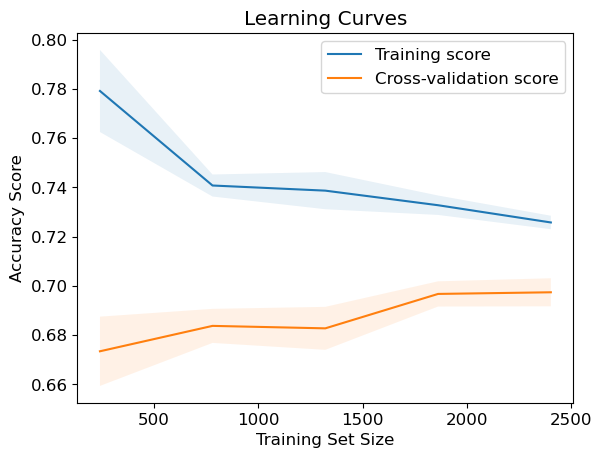

In [582]:
svm.get_learning_curve(X, y)

### Feature Selection

In [583]:
# Doing feature selection with the best SVM model
svm.sfs()
svm_best_features = svm.get_best_features(X_train, y_train)
print(svm_best_features)
svm_best_features += unique_genres
svm.fit_with_features(X_train_genres, y_train, svm_best_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.9s finished

[2024-05-17 16:01:15] Features: 1/10 -- score: 0.6525176862255514[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.8s finished

[2024-05-17 16:01:18] Features: 2/10 -- score: 0.6729088639200999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.7s finished

[2024-05-17 16:01:21] Features: 3/10 -- score: 0.694548481065335[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'title_year', 'movie_facebook_likes']


In [584]:
# Now checking accuracy with the best features
y_pred_svm_ft = svm.predict(X_test_genres[svm_best_features])
svm_accuracy_ft = accuracy_score(y_test, y_pred_svm_ft)
svm_cv_scores = cross_val_score(svm_best, X_genres, y, cv=5)
print(f'SVM Accuracy with selected features: {svm_accuracy_ft}')
print(f'SVM Cross Validation Score with Best Features: {svm_cv_scores.mean()}')
print(classification_report(y_test, y_pred_svm_ft))

SVM Accuracy with selected features: 0.7337770382695508
SVM Cross Validation Score with Best Features: 0.7380188574597892
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        48
           2       0.74      0.93      0.83       377
           3       0.70      0.54      0.61       152
           4       0.69      0.47      0.56        19

    accuracy                           0.73       601
   macro avg       0.43      0.39      0.40       601
weighted avg       0.67      0.73      0.69       601



/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


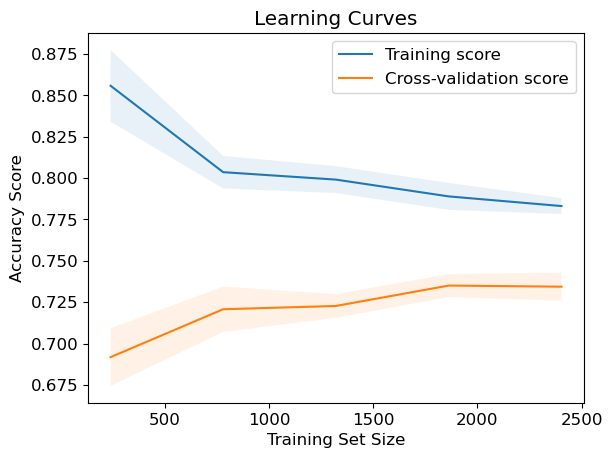

In [585]:
svm.get_learning_curve(X_genres[svm_best_features], y)

## Model 2: Logistic Regression

In [586]:
from sklearn.linear_model import LogisticRegression

### Tuning Hyperparameters

In [587]:
# Logistic Regression Model
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Types of penalties
    'solver': ['saga'],  # Solvers
    'max_iter': [100,200,1000]  # Number of iterations
}
logr = Model(LogisticRegression(), param_grid)
logr.grid_search()
logr_best, logr_params, logr_cv = logr.get_best_model(X_train, y_train)

/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWa

In [588]:
# Printing parameters for the best estimator including kernel)
print(logr_params)
y_pred_logr = logr.predict(X_test)
logr_accuracy = accuracy_score(y_test, y_pred_logr)
print(f'Logistic Regression Accuracy: {logr_accuracy}')
print(f'Logistic Regression Cross Validation Score Best: {logr_cv}')
logr_cv_scores = cross_val_score(logr_best, X, y, cv=5)
print(f'Logistic Regression Cross Validation Score Average: {logr_cv_scores.mean()}')
print(classification_report(y_test, y_pred_logr))

{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression Accuracy: 0.6522462562396006
Logistic Regression Cross Validation Score Best: 0.6213097713097714


/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Cross Validation Score Average: 0.6271647254575707
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        48
           2       0.65      0.99      0.79       377
           3       0.69      0.12      0.20       152
           4       0.00      0.00      0.00        19

    accuracy                           0.65       601
   macro avg       0.27      0.22      0.20       601
weighted avg       0.58      0.65      0.54       601



/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/softwar

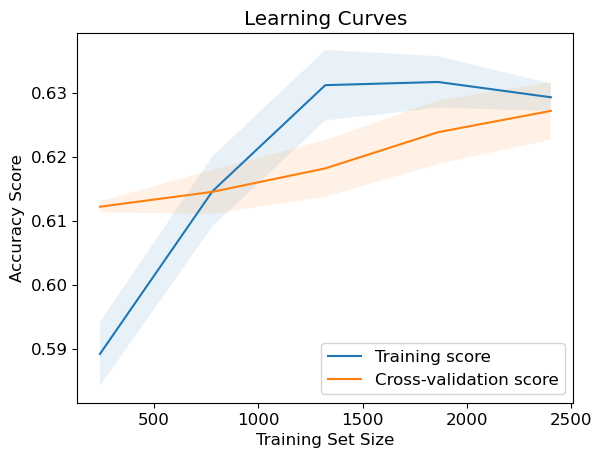

In [589]:
logr.get_learning_curve(X, y)

### Feature Selection

In [590]:
# Doing feature selection with the best logr model
logr.sfs()
logr_best_features = logr.get_best_features(X_train, y_train)
print(logr_best_features)
logr_best_features += unique_genres
logr.fit_with_features(X_train_genres, y_train, logr_best_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2024-05-17 16:02:13] Features: 1/10 -- score: 0.6629213483146067[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s finished

[2024-05-17 16:02:14] Features: 2/10 -- score: 0.6779026217228464[Parallel(n_jo

['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes']


In [591]:
# Now checking accuracy with the best features
y_pred_logr_ft = logr.predict(X_test_genres[logr_best_features])
logr_accuracy_ft = accuracy_score(y_test, y_pred_logr_ft)
logr_cv_scores = cross_val_score(logr_best, X_genres, y, cv=5)
print(f'Logistic Regression Accuracy with selected features: {logr_accuracy_ft}')
print(f'Logistic Regression Cross Validation Score with Best Features: {logr_cv_scores.mean()}')
print(classification_report(y_test, y_pred_logr_ft))

/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Accuracy with selected features: 0.7204658901830283
Logistic Regression Cross Validation Score with Best Features: 0.6294941763727121
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        48
           2       0.72      0.95      0.82       377
           3       0.71      0.44      0.54       152
           4       0.89      0.42      0.57        19

    accuracy                           0.72       601
   macro avg       0.46      0.36      0.39       601
weighted avg       0.66      0.72      0.67       601



/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

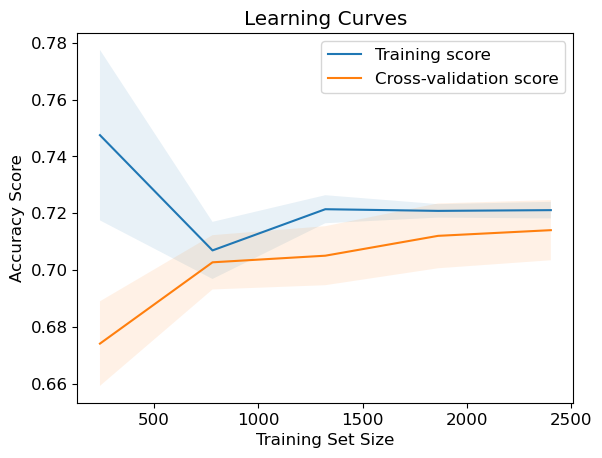

In [592]:
logr.get_learning_curve(X_genres[logr_best_features], y)

## Model 3: Random Forest

In [603]:
from sklearn.ensemble import RandomForestClassifier

### Tuning Hyperparameters

In [615]:
# Random Forest Model
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'max_features': ['auto', 'sqrt', 'log2']}
rf = Model(RandomForestClassifier(random_state=42), param_grid)
rf.grid_search()
rf_best, rf_params, rf_cv = rf.get_best_model(X_train, y_train)

/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remo

In [616]:
# Printing parameters for the best estimator including kernel)
print(rf_params)
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy}')
print(f'Random Forest Cross Validation Score Best: {rf_cv}')
rf_cv_scores = cross_val_score(rf_best, X, y, cv=5)
print(f'Random Forest Cross Validation Score Average: {rf_cv_scores.mean()}')
print(classification_report(y_test, y_pred_rf))

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
Random Forest Accuracy: 0.7071547420965059
Random Forest Cross Validation Score Best: 0.7153482328482329


/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remo

Random Forest Cross Validation Score Average: 0.71238768718802
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        48
           2       0.72      0.92      0.81       377
           3       0.64      0.45      0.53       152
           4       0.62      0.42      0.50        19

    accuracy                           0.71       601
   macro avg       0.40      0.36      0.37       601
weighted avg       0.64      0.71      0.66       601



/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remo

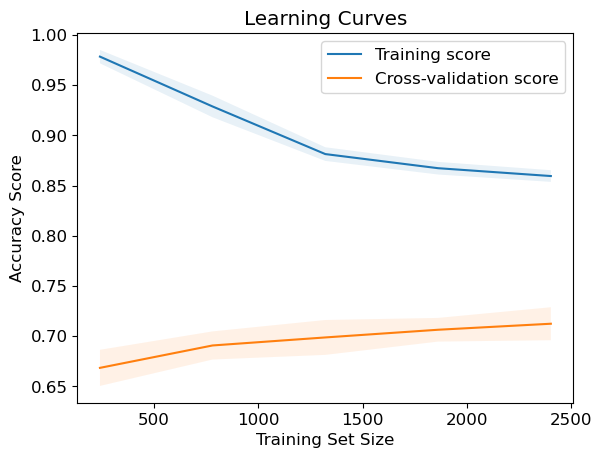

In [617]:
# Plotting learning curve for random forest
rf.get_learning_curve(X, y)

### Feature Selection

In [623]:
# Doing feature selection with the best random forest model
rf.sfs()
rf_best_features = rf.get_best_features(X_train, y_train)
print(rf_best_features)
rf_best_features += unique_genres
rf.fit_with_features(X_train_genres, y_train, rf_best_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: Fut

['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'title_year', 'movie_facebook_likes', 'average_degree_centrality']


In [624]:
# Now checking accuracy with the best features
y_pred_rf_ft = rf.predict(X_test_genres[rf_best_features])
rf_accuracy_ft = accuracy_score(y_test, y_pred_rf_ft)
rf_cv_scores = cross_val_score(rf_best, X, y, cv=5)
print(f'Random Forest Accuracy with selected features: {rf_accuracy_ft}')
print(f'Random Forest Cross Validation Score with Best Features: {rf_cv_scores.mean()}')
print(classification_report(y_test, y_pred_rf_ft))

/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remo

Random Forest Accuracy with selected features: 0.7287853577371048
Random Forest Cross Validation Score with Best Features: 0.71238768718802
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        48
           2       0.74      0.94      0.83       377
           3       0.69      0.51      0.59       152
           4       0.67      0.32      0.43        19

    accuracy                           0.73       601
   macro avg       0.42      0.35      0.37       601
weighted avg       0.66      0.73      0.68       601



/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remo

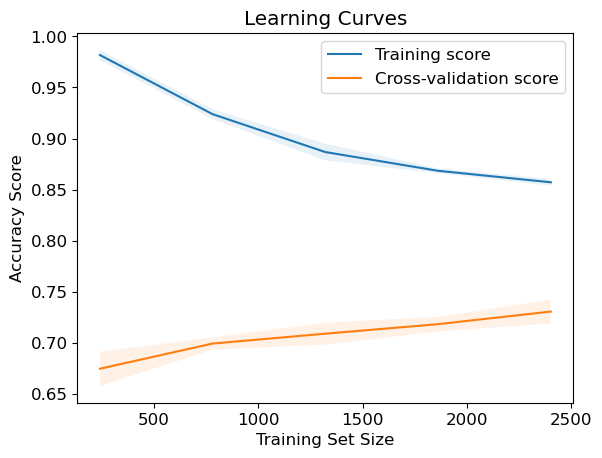

In [625]:
# Plotting learning curve for random forest with best features
rf.get_learning_curve(X_genres[rf_best_features], y)

## Model 4: Ensemble Model by Stacking

In [600]:
from sklearn.ensemble import StackingClassifier

In [601]:
estimators = [('rf', rf_best),('logr', logr_best)]
stack = StackingClassifier(estimators=estimators, final_estimator=logr_best)
stack.fit(X_train_genres, y_train)
y_pred_stack = stack.predict(X_test_genres)
stack_cv_scores = cross_val_score(stack, X_genres, y, cv=5)
print(f'Stacking Classifier Cross Validation Score: {stack_cv_scores.mean()}')

/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/s

Stacking Classifier Cross Validation Score: 0.7310299500831947


/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/taherm/software/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explici

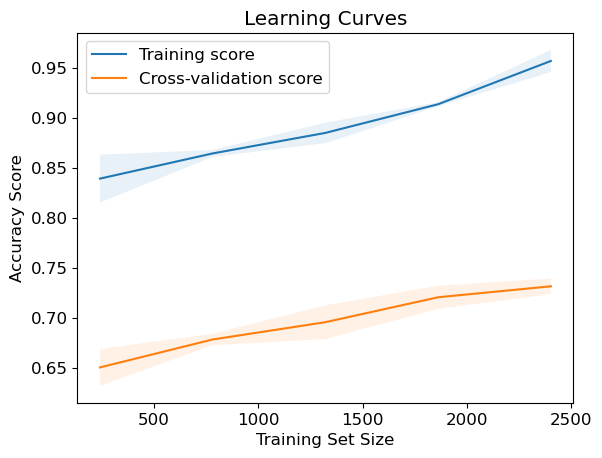

In [602]:
# Plotting learning curve for stacking
train_sizes, train_scores, test_scores = learning_curve(stack, X_genres, y, cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curves")
plt.legend()
plt.show()